In [1]:
#importing libraries
import pandas as pd
import numpy as np
import html
import re
import warnings 
import nltk
from nltk.tokenize import TweetTokenizer #for tokenize text 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS


#Step3 and Step4
from sklearn.cross_validation import train_test_split #for splitting data into train and test
from sklearn.feature_extraction.text import CountVectorizer #for vectorize text into sparse matrix 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from io import StringIO
from sklearn.model_selection import cross_val_score

#step5
from IPython.display import display
from sklearn.metrics import confusion_matrix

#BONUS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

%matplotlib inline
warnings.filterwarnings("ignore")

#For display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

F:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Step1 Cleaning Data

Reading data from both airline csv file and generic text file, create data frame for both data set<br>
Cleaning Step 1.Set all characters in the text are in lowercase



In [2]:
tweets = pd.read_csv('US_airline_tweets.csv',encoding="utf-8")
data_g = pd.read_csv('generic_tweets.txt', sep=",",encoding="utf-8")

data = tweets.iloc[:,[5,1]]
df = data
data.columns = ['text', 'sentiment']


data_g = data_g.iloc[:,[5,0]]
data_g = data_g.rename(columns={'class': 'sentiment'})#Rename class to sentiment

#All characters in the text are in lowercase
data_g['text'] = data_g['text'].str.lower()
data['text'] = data['text'].str.lower()

#Displace both data sets
data_g.head()
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


,text,sentiment
0,@virginamerica plus you've added commercials t...,positive
1,@virginamerica it's really aggressive to blast...,negative
2,@virginamerica and it's a really big bad thing...,negative
3,@virginamerica seriously would pay $30 a fligh...,negative
4,"@virginamerica yes, nearly every time i fly vx...",positive


After taking a close look at dataset, an additional column of mention was made. 
This is because 'mention' determins the airline of a given tweet 

In [3]:
#Make another column to show each text 'mention'
df['mention'] = df.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(','.join)

Cleaning Step 2.Html character codes  are replaced with an ASCII equivalent.

In [4]:
def replace_ascii(data):
    data = html.unescape(data)
    return data
data['text'] = replace_ascii(data['text'])
data_g['text'] = replace_ascii(data_g['text'])

Clearning step3 Remove ALL himl tags and attributes <br>
Clearning step4 Remove ALL URLS <br>
Use Regex to do it in a step:<br>

In [5]:
# removing every thing except text 
data['text']=data['text'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])","")
data_g['text'] = data_g['text'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])","")

# now tokenize text
data['text']=data['text'].apply(nltk.word_tokenize)
data_g['text']=data_g['text'].apply(nltk.word_tokenize)



Clearning step5 Remove stopword(the most common words in a language):nltk module contains a list of stop words <br>
Convert sentiment positve and negative to 1 and 0.

In [6]:
# removing stopword 
stopwords = nltk.corpus.stopwords.words('english')
data['text']=data['text'].apply(lambda x: [y for y in x if y not in stopwords])
data_g['text']=data_g['text'].apply(lambda x: [y for y in x if y not in stopwords])


#transforming postive to 1, negative to 0
sentiment = sorted(data['sentiment'].unique())
sentiment_mapping = dict(zip(sentiment, range(0, len(sentiment) + 1)))
data['sentiment']  = data['sentiment'].map(sentiment_mapping).astype(int)


Detoknize 'test' column in dataframe for vectorizing in later section<br>
Attention:Only run once, otherwise words will be detoknize twice

In [7]:
data['text'] = data['text'].str.join(" ")
data_g['text'] = data_g['text'].str.join(" ")

#Displace both data frame after cleaning
data.head()
data_g.head()


,text,sentiment,mention
0,plus youve added commercials experience tacky,1,virginamerica
1,really aggressive blast obnoxious entertainmen...,0,virginamerica
2,really big bad thing,0,virginamerica
3,seriously would pay flight seats didnt playing...,0,virginamerica
4,yes nearly every time fly vx ear worm wont go ...,1,virginamerica


,text,sentiment
0,awww thats bummer shoulda got david carr third...,0
1,upset cant update facebook texting might cry r...,0
2,dived many times ball managed save rest go bounds,0
3,whole body feels itchy like fire,0
4,behaving im mad cant see,0


# STEP2 EXPLORATORY ANALYSIS

A column of mentions already made to determines the airline of a given tweet.

In [8]:
sentiment  = data['sentiment'].value_counts()
sentiment

0    9178
1    2363
Name: sentiment, dtype: int64

There are 9178 negative tweets when only 2363 positive tweets.

<Figure size 360x360 with 0 Axes>

([<matplotlib.patches.Wedge at 0x2cd3e7008d0>,
 [Text(0.250164,-1.07118,'Negative'), Text(-0.250164,1.07118,'Positive')],
 [Text(0.136453,-0.584278,'79.5%'), Text(-0.136453,0.584278,'20.5%')])

(-1.1054770868997805,
 1.1058720212214983,
 -1.1066112213827837,
 1.1243834554566352)

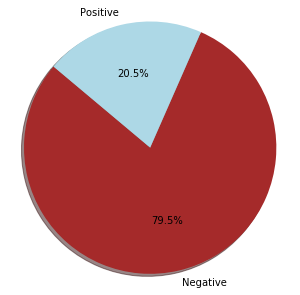

In [9]:
# pie plot for total percentage of airline sentiment
plt.figure(figsize=(5,5))
labels = 'Negative', 'Positive'
sizes = [9178, 2363]
colors = ['brown', 'lightblue']
explode = (0, 0) 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

From the plot you can see there are 79.5 percent of tweets are negative when only 20.5 percent of positive 

united           2877
usairways        2226
americanair      2033
southwestair     1578
jetblue          1340
virginamerica     301
Name: mention, dtype: int64

<Figure size 720x576 with 0 Axes>

<BarContainer object of 6 artists>

Text(0.5,0,'Airline')

Text(0,0.5,'Number of Tweets for Airline')

Text(0.5,1,'Totol number of each type airline')

([<matplotlib.axis.XTick at 0x2cd3e6f6ba8>,
 <a list of 6 Text xticklabel objects>)

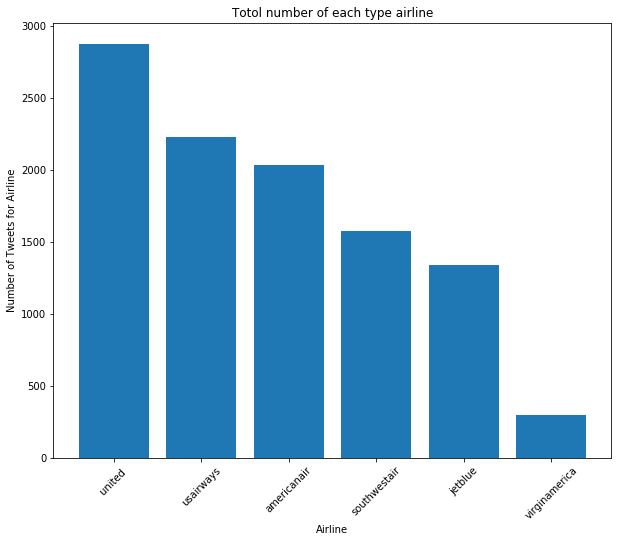

In [10]:
airline = data['mention'].value_counts()
#len(airline)
airline[0:6]

plt.figure(figsize=(10,8))
plt.bar([1,2,3,4,5,6],airline[0:6])
plt.xlabel("Airline")
plt.ylabel("Number of Tweets for Airline")
plt.title("Totol number of each type airline")
plt.xticks([1,2,3,4,5,6],['united ','usairways','americanair','southwestair','jetblue','virginamerica'],rotation=45)

As you can see, virginamerica has the least amount of tweets when united has the most amount of tweets.

Plot a worldCloud to see what words that showed in the generic_text that are most frequently

<Figure size 864x864 with 0 Axes>

(-0.5, 1999.5, 1499.5, -0.5)

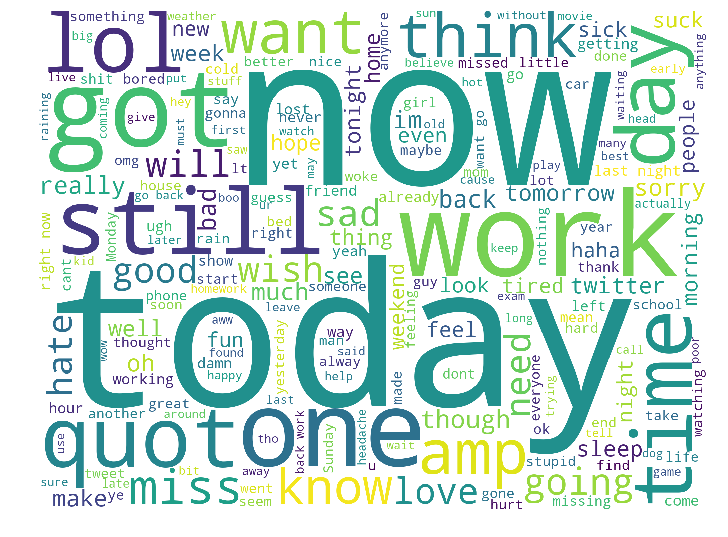

In [11]:
data_generic_wordcloud = pd.read_csv('generic_tweets.txt', sep=",")
#data_g
df_generic_wordcloud = data_generic_wordcloud.iloc[:,[5,0]]


df_generic_wordcloud=data_generic_wordcloud[data_generic_wordcloud['class'] == 0] 
# join tweets to a single string
words = ' '.join(df_generic_wordcloud['text'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Words like "today", "now" , "work","got","still" showed frequently in negative tweets.

# STEP3 and 4 MODEL PREPARATION and Model Implementation


#### Split the generic tweets randomly into training data (70%) and test data (30%).
Test_test_split from module sklearn was used

In [12]:
X = data_g['text']
y = data_g['sentiment']
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 random_state = 20,
                                                 test_size = 0.3)
print('The length of the trainning set are {}'.format(len(X_train)))
print('The length of the test set are {}'.format(len(X_test)))

The length of the trainning set are 140000
The length of the test set are 60000


#### Usually there are two ways to extract features from text(NLP)
#### Bag-of-Words Features and TF-IDF(term frequency-inverse document frequency)
#### TF-IDF are demonstrated below:
TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.


w = tf(w)*idf(w) <br>
tf(w) = (number of times the word appears in a document)/(total number of words in the document)
idf(w) = log(number of documents / number of ducuments that contain word w)

tag each n-gram by its part of speech and then use
the frequency of each part of speech as the features of the model.

In [13]:
#CountVectorizer just counts the word frequencies 
#With the TFIDFVectorizer the value increases proportionally to count,
#but is offset by the frequency of the word in the corpus.
#Here we use CountVectorizer
#ngram_range = (1,1) for one-word token,means only unigrams
#null accuracy: accuracy that could be achieved by always predicting the most frequent class

Lreg = LogisticRegression()
vectorizer = CountVectorizer(ngram_range = (1,1),
                             stop_words=None)
pipeline = Pipeline([
    ('vectorizer',vectorizer),
    ('classifier',Lreg)
])


if len(X_test[y_test == 0])/(len(X_test)*1)>0.5:
        null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1)
else:
        
        null_accuracy = 1 - (len(X_test[y_test == 0]) / (len(X_test)*1))
        
sentiment_fit = pipeline.fit(X_train,y_train)
y_pred = sentiment_fit.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)

print("The null accuracy is {0:.4f}".format(null_accuracy))
print("The accuracy of the model is {0:.4f}".format(accuracy))



The null accuracy is 0.5005
The accuracy of the model is 0.7672


After trained the model using generic text<br>
we than apply the model on the Us airline<br>
Threshold = 0.4<br>
Any observations with scores higher than the threshold are then predicted as the positive class <br>
and scores lower than the threshold are predicted as the negative class

In [14]:
#After trained the model using generic text
#we than apply the model on the Us airline
#Threshold = 0.4(This value can be tuned)
# Any observations with scores higher than the threshold are then predicted as the positive class 
#and scores lower than the threshold are predicted as the negative class
air_sentiment=[]
for sentiment in data['sentiment']:
    air_sentiment.append(sentiment)
    
sentiment_fit_air = pipeline.fit(X_train,y_train)
y_pred_air = sentiment_fit_air.predict_proba(data['text'])[:,1] >  0.4
#where 0.4 is a Threshold

accuracy_air = accuracy_score(air_sentiment,y_pred_air)
print("The accuracy of the model use Us airline data is {0:.4f}".format(accuracy_air))

The accuracy of the model use Us airline data is 0.6936


Accuracy of the model use on US airline is 69.36% which is not bad. There are few paramters can be tuned around to get better accuracy. 

#### Train a multi-class logistic regression model to predict the reason for the negative tweets. 
Step 1:cleaning data

In [15]:
tweets = pd.read_csv('US_airline_tweets.csv')
data_negative = tweets.iloc[:,[5,1,2]].dropna()
data_negative['mention'] = data_negative.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(','.join)
#data_negative
data_negative['text'] = data_negative['text'].str.lower()
data_negative['text'] = replace_ascii(data_negative['text'])
data_negative['text'] = data_negative['text'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])","")
data_negative['text'] = data_negative['text'].apply(nltk.word_tokenize)
data_negative['text'] = data_negative['text'].apply(lambda x: [y for y in x if y not in stopwords])
data_negative['text'] = data_negative['text'].str.join(" ")

#Display counts for negative reasons 
#Display data frame
data_negative['negative_reason'].value_counts()
data_negative.head()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negative_reason, dtype: int64

,text,sentiment,negative_reason,mention
1,really aggressive blast obnoxious entertainmen...,negative,Bad Flight,VirginAmerica
2,really big bad thing,negative,Can't Tell,VirginAmerica
3,seriously would pay flight seats didnt playing...,negative,Can't Tell,VirginAmerica
11,sfopdx schedule still mia,negative,Late Flight,VirginAmerica
13,flew nyc sfo last week couldnt fully sit seat ...,negative,Bad Flight,VirginAmerica


Convert negative reasons to ID <br>
Easy to visualize and get ready for modelling

In [16]:
data_negative['category_id'] = data_negative['negative_reason'].factorize()[0]

category_id_df = data_negative[['negative_reason', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'negative_reason']].values)
data_negative.head()

,text,sentiment,negative_reason,mention,category_id
1,really aggressive blast obnoxious entertainmen...,negative,Bad Flight,VirginAmerica,0
2,really big bad thing,negative,Can't Tell,VirginAmerica,1
3,seriously would pay flight seats didnt playing...,negative,Can't Tell,VirginAmerica,1
11,sfopdx schedule still mia,negative,Late Flight,VirginAmerica,2
13,flew nyc sfo last week couldnt fully sit seat ...,negative,Bad Flight,VirginAmerica,0


In [17]:
#Modelling use tfidf
#TfidVectorizer normalizes its results compared to CountVectorizer(used above)

#ngram_range = (1,2)means consider both unigrams and bigrams
#sublinear_df is set to True to use a logarithmic form for frequency.
#norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
#min_df is the minimum numbers of documents a word must be present in to be kept
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        norm='l2', 
                        min_df=5,
                        ngram_range=(1, 2), 
                       )
features = tfidf.fit_transform(data_negative.text).toarray()
labels = data_negative.category_id

To train supervised classifiers, first transformed the “text” into a vector of numbers.<br>
Then explored vector representations such as TF-IDF weighted vectors.<br>
After having this vector representations of the text, then train supervised classifiers to train unseen “text” and predict the “negative reasons” 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(data_negative['text'], 
                                                    data_negative['negative_reason'],
                                                    test_size = 0.3, 
                                                    random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [19]:
#Fit logistic regression model
#cv = cross-validation generator
#It Determines the cross-validation splitting strategy
models = [LogisticRegression(random_state=0)]
cv = 5
cv_df = pd.DataFrame(index=range(cv * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracy = cross_val_score(model, features, labels, scoring='accuracy', cv=cv)
    for fold_idx, accuracy in enumerate(accuracy):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [20]:
print("The accuracy of the model to predict negative reasons is {0:.4f}".format(accuracy.mean()))

The accuracy of the model to predict negative reasons is 0.5917


# Step 5 Discussion :

step 1: its basically cleaning process<br>
step 2：From the plot in step2 we can see that the order for most to least number of tweets is<br>


United , Usairway, Americanair, Southwestai, jetblue ,Virginamerica. <br>
In addition, from generic tweets:Words like "today", "now" , "work","got","still" showed frequently in negative tweets.<br>
step 3: I Split the generic tweets randomly into training data (70%) and test data (30%) and use tf-idf method to train the model.<br>step 4:
The null accuracy trained on generic tweets is 0.5005<br>
The accuracy trained on generic tweets of the model is 0.7672<br>
The accuracy of the model used on Us airline data is 0.6936<br>
Accuracy of the model use on US airline is 69.36% which is not bad. There are few paramters(ex.Threshold) can be tuned around to get better accuracy. <br>
The accuracy of the us negative tweets model(second model) to predict negative reasons is 0.5917<br>
step 5:

Based on plots from Bonus section and step 2: It is easy to see that public have more negative motions on United , Usairway and Americanair than Southwestair, jetblue and Virginamerica.<br>
From my observations, there are many tweets that marked 'Can't Tell' predicted as 'Customer Service Issue' <br>
Reasons that fialed:<br>
1. two categories are too similar with each other.<br>
2. mistakes that found in the datasets(clearly number 4158 is a customer service issue but marked as cant tell)

For example number 10594 and 524 tweets were predicted as Customer Service Issue.<br>
Accuracy can be imporved by combine similar features together and delete low frequency words.


In [21]:
data_negative['text'][6425]
data_negative['text'][4158]

'worst postpone trip cant accommodate guests like neveragain'

'told call cust service monday'

In [22]:
#Find prediction failures
model = LogisticRegression()
category_id_df = data_negative[['negative_reason', 'category_id']].drop_duplicates().sort_values('category_id')

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data_negative.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)


for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(data_negative.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['negative_reason', 'text']])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

'Can't Tell' predicted as 'Bad Flight' : 8 examples.


,negative_reason,text
4557,Can't Tell,charge much moving full flight earlier flight ...
2692,Can't Tell,wifi ewr lounge reminds old days dial
9452,Can't Tell,said aa provide inflight wifi routes china bas...
3170,Can't Tell,guys working planes
2391,Can't Tell,please send help asap flight chicago seat c ai...
3873,Can't Tell,wifi worst investment ever made
10887,Can't Tell,food hour flight columbus phoenix starving pis...
5908,Can't Tell,hopefully flight seattle boston pm wifi first ...


'Customer Service Issue' predicted as 'Bad Flight' : 6 examples.


,negative_reason,text
7007,Customer Service Issue,awesome doors close minutes flight leaves minu...
3035,Customer Service Issue,annnnddddd im going lose first class seat flig...
7117,Customer Service Issue,booked flight mnth ago seat confirmed small pl...
9032,Customer Service Issue,im flight finally air enough food feed custome...
2549,Customer Service Issue,board customers onto plane pilot thing expedit...
11496,Customer Service Issue,nice know paid seat sold seat bought rd seat g...


'Flight Attendant Complaints' predicted as 'Bad Flight' : 6 examples.


,negative_reason,text
298,Flight Attendant Complaints,group e told room bins got plane room least ba...
1964,Flight Attendant Complaints,hate get bumped seat ive selected amp empty ro...
11289,Flight Attendant Complaints,first sister zero food cross country flight ty...
2730,Flight Attendant Complaints,abused threatened forced travel lower cabine l...
10437,Flight Attendant Complaints,upon entering plane stewardesses water dont pl...
8847,Flight Attendant Complaints,would pleased reassess business practices goal...


'Bad Flight' predicted as 'Can't Tell' : 38 examples.


,negative_reason,text
8555,Bad Flight,please secure footrest shelf business class ai...
9281,Bad Flight,dont worry ill sending letter expect compensat...
1265,Bad Flight,everytime fly ur airline hate even thanks terr...
3570,Bad Flight,heart southwest commercials aimed satisfy nano...
1105,Bad Flight,considering currently gold make jump upcoming ...
3162,Bad Flight,dang thought teleportation device ua
4086,Bad Flight,please refund ticket terrible experience south...
1385,Bad Flight,tried failed still wifi ever last row middle f...
4311,Bad Flight,cool plane said left terminal diff city cold b...
1561,Bad Flight,would think would clean ramps jet stuck snow n...


'Late Flight' predicted as 'Can't Tell' : 28 examples.


,negative_reason,text
6121,Late Flight,dont cling safety card safety really issue fli...
6838,Late Flight,spent hours got nowhere entire experience epic...
6024,Late Flight,boarding im really impressed ive learnt valuab...
4703,Late Flight,friend lucky enough see destinationdragons liv...
8273,Late Flight,bad planes amp gate changes lots exercise trav...
5632,Late Flight,coming thought tampa
1330,Late Flight,stay h traveling ans sleeping airports floor
6512,Late Flight,stood last night im giving second chance im bo...
10466,Late Flight,deplaned rd fucking time fuck aa
11280,Late Flight,u cant spell airline trusted get home time saf...


'Customer Service Issue' predicted as 'Can't Tell' : 65 examples.


,negative_reason,text
8163,Customer Service Issue,pretty hilarious want finish awful experience ...
4362,Customer Service Issue,traveling one got miscommunicated
2469,Customer Service Issue,thanks great news u wont refund tickets due ba...
4399,Customer Service Issue,well car amp free place stay known unacceptabl...
2392,Customer Service Issue,define appreciate doubt worst major airline us...
4859,Customer Service Issue,didnt see travel compete unused funds expirati...
733,Customer Service Issue,checking status claim going months attention u...
11471,Customer Service Issue,real life aa like real life emailingcallingdmi...
10103,Customer Service Issue,liar precipitation day degrees dont pacify loo...
4683,Customer Service Issue,dont like new schedule nonstops phl fll pbi fr...


'Flight Booking Problems' predicted as 'Can't Tell' : 19 examples.


,negative_reason,text
8121,Flight Booking Problems,easily ridiculous experience trying spend mone...
7367,Flight Booking Problems,chairman preferred lifetime miles us air rewar...
11288,Flight Booking Problems,confusing web sitecomplicated ordering process...
10420,Flight Booking Problems,pay extra cos flight longer available wouldnt ...
1110,Flight Booking Problems,bull crap spent recent trip thats small change...
3262,Flight Booking Problems,mileageplus signup page broken
2094,Flight Booking Problems,certainly
31,Flight Booking Problems,hey first time flyer next week excited im hard...
7110,Flight Booking Problems,lots fun removed top list manually readded bot...
7013,Flight Booking Problems,fly back charlotte different airport guys flex...


'Lost Luggage' predicted as 'Can't Tell' : 15 examples.


,negative_reason,text
505,Lost Luggage,back expensive holiday worked year pay ruined ...
2625,Lost Luggage,fingers crossed capable getting baggage point ...
6962,Lost Luggage,able locate insane trust pay look things lost
4892,Lost Luggage,along passengers repeatedly asked southwest pe...
1542,Lost Luggage,fly united checked baggage never find
6951,Lost Luggage,patient especially first time never fly
6957,Lost Luggage,yes know industry procedure baggage thanks hel...
9747,Lost Luggage,ill give reward whoever finds returns thurs fl...
2521,Lost Luggage,thanks formed submitted im betting someone wou...
2882,Lost Luggage,yes


'Flight Attendant Complaints' predicted as 'Can't Tell' : 19 examples.


,negative_reason,text
11444,Flight Attendant Complaints,let employees treat loyal customers attackingb...
5105,Flight Attendant Complaints,ive airline everyone else great soured whole e...
3476,Flight Attendant Complaints,grounded flights bc equipment problems amp rud...
1160,Flight Attendant Complaints,wanted point one united crew sympathetic quest...
2048,Flight Attendant Complaints,u guys suck ill never fly u ur supervisors suck
4874,Flight Attendant Complaints,want file formal complaint disgruntled employe...
44,Flight Attendant Complaints,airline awesome lax loft needs step game dirty...
2153,Flight Attendant Complaints,never fails flying fc order ravioli get chicke...
7399,Flight Attendant Complaints,providing pilots flights new feature merger ef...
6981,Flight Attendant Complaints,really embarrassing asking complimentary drink...


'Cancelled Flight' predicted as 'Can't Tell' : 8 examples.


,negative_reason,text
6681,Cancelled Flight,much paid fees plus hotel food changes could f...
8815,Cancelled Flight,spend cost flight get free room transportation...
7895,Cancelled Flight,even alternate options allready fulleven hotel...
7927,Cancelled Flight,hotel voucher everyone get one mewhat arrived ...
681,Cancelled Flight,fucked voided ticket kept money even apology n...
4322,Cancelled Flight,im line airport right cover hotel fair sleep a...
1737,Cancelled Flight,pay hotel im broke student help
2886,Cancelled Flight,right thing reinstate tickets voided unitedfail


'Bad Flight' predicted as 'Late Flight' : 56 examples.


,negative_reason,text
8635,Bad Flight,flight phf clt terminal cant get plane yet nee...
1723,Bad Flight,cabin pressurization issues pretty serious fli...
661,Bad Flight,empathizes w disappointment stclass flight wno...
247,Bad Flight,flight vx headed la jfk dirtiest va plane ever...
3968,Bad Flight,plane switch meant back plane disappointed
6124,Bad Flight,flight forced return ny malfunction land count...
1465,Bad Flight,broken light mins get bridge gate airplane par...
4720,Bad Flight,first flight ever flight already technical iss...
11404,Bad Flight,plane didnt land identical worse conditions gr...
9668,Bad Flight,late flight boarded exit rows taken could gott...


'Can't Tell' predicted as 'Late Flight' : 37 examples.


,negative_reason,text
7533,Can't Tell,lose pilot
9785,Can't Tell,bs noise late flight norahm
3108,Can't Tell,getting ridiculous missing connection
2125,Can't Tell,miss continental days
1584,Can't Tell,weight restriction well try get many plane
5789,Can't Tell,ok got far atlantic city due jfk closed get us...
8568,Can't Tell,bledsoe thanks feedback alan thx help watch fl...
2622,Can't Tell,flight heavy fly back palm springs air mins
2363,Can't Tell,flight specific last two probably feet apart w...
2245,Can't Tell,making miss big snow montana cool


'Customer Service Issue' predicted as 'Late Flight' : 41 examples.


,negative_reason,text
8593,Customer Service Issue,flight cost happens fly problems come us times
5787,Customer Service Issue,note time taken flight still listed time im on...
1857,Customer Service Issue,please dont take membership away
10805,Customer Service Issue,im home amp hr late flight thanks service cent...
8525,Customer Service Issue,appreciate calls flights delayed recorded msg ...
6548,Customer Service Issue,shout crew flight headed back big apple kept g...
10960,Customer Service Issue,dropping ball catering plane switch gate atten...
2444,Customer Service Issue,worst major us airline proof theyre boarding p...
6723,Customer Service Issue,thanks making impossibly expensive change flig...
9047,Customer Service Issue,stop reposting autoresponse return flight home...


'Flight Booking Problems' predicted as 'Late Flight' : 8 examples.


,negative_reason,text
11396,Flight Booking Problems,changed flight bna ahead weather slammed cost ...
5955,Flight Booking Problems,flying denver march st flight itenary keeps ge...
1133,Flight Booking Problems,cant find late flight evening flights airports...
10214,Flight Booking Problems,get flight change air delays causing missed co...
4693,Flight Booking Problems,used exclusively fly sw late flightly direct f...
11408,Flight Booking Problems,would like refund flight delayed flight times ...
2283,Flight Booking Problems,thats still one day visa expiring june booked ...
10626,Flight Booking Problems,please stop changing flights spring break th time


'Lost Luggage' predicted as 'Late Flight' : 6 examples.


,negative_reason,text
7242,Lost Luggage,seriously ridiculous shouldnt wait hour luggag...
7019,Lost Luggage,happened u couldnt get us home next day flydel...
1423,Lost Luggage,thanks occur guys hours extra get bag due dela...
7846,Lost Luggage,sitting runway hours leave airport wo luggage ...
9534,Lost Luggage,tell means work need estimated time arrival pl...
2972,Lost Luggage,yes supposed pm board meeting tomorrow fingers...


'Flight Attendant Complaints' predicted as 'Late Flight' : 30 examples.


,negative_reason,text
874,Flight Attendant Complaints,today take flight san francisco refuse let us ...
9113,Flight Attendant Complaints,please staff flights approproately entire flig...
4304,Flight Attendant Complaints,staff really kind flight delay luggage disappo...
11233,Flight Attendant Complaints,flight iad lax sat hrs ground crew couldnt dri...
866,Flight Attendant Complaints,arriving airport hours departure time still mi...
9539,Flight Attendant Complaints,lots upset people freezing terminal gate agent...
7879,Flight Attendant Complaints,hello four hours since plane landed flt phx jf...
525,Flight Attendant Complaints,people getting pretty tired action solving pro...
1795,Flight Attendant Complaints,god damn fucking crew wont till youve known ho...
2652,Flight Attendant Complaints,concerned close club paid alot last flight p c...


'Cancelled Flight' predicted as 'Late Flight' : 28 examples.


,negative_reason,text
6155,Cancelled Flight,bags hv posted board flight carsl switched car...
10458,Cancelled Flight,hahahaha crazy well heres another night airport
9800,Cancelled Flight,flights via united arrive dfw car parked iah
8761,Cancelled Flight,missed uncles funeral hope find another flight...
11330,Cancelled Flight,flight miami dallas monday rescheduled tuesday
7701,Cancelled Flight,us costing get home today reason send receipts...
3089,Cancelled Flight,landed day late flight almost sleep feel sorry...
6148,Cancelled Flight,stranded passengers arent helped get another f...
7501,Cancelled Flight,would let us switch different set flights coul...
10460,Cancelled Flight,youre sorry enough compensate either extended ...


'longlines' predicted as 'Late Flight' : 17 examples.


,negative_reason,text
8452,longlines,dca pm still due mechanical issues lack snacks...
810,longlines,ua feb point overselling flights bad making pe...
9335,longlines,rampers gate b dfw waiting marshaled
11286,longlines,second sat tarmac hrs told would mins
5709,longlines,ridiculous hours coming waiting deplane newbor...
9464,longlines,rampers gate b dfw waiting marshaled
8722,longlines,still waiting captain reports hes called times...
4969,longlines,thanks told couldnt hours ago plane left tried...
9128,longlines,told gates open ord needed wait mins still wai...
10873,longlines,point u need tell passengers going jfk waiting...


'Bad Flight' predicted as 'Customer Service Issue' : 59 examples.


,negative_reason,text
2634,Bad Flight,would hard worse last time im sure youll give ...
1763,Bad Flight,additionally husband paid tv service amp stopp...
2696,Bad Flight,tried already amp tried forgetting wifi networ...
3742,Bad Flight,wasnt able sit seat since guy next using worst...
7113,Bad Flight,usually sorry doesnt involve moving people mid...
1793,Bad Flight,fire yr rep refused put flight boarding pass s...
1559,Bad Flight,good luck noenertainmentonhourflights strategy...
9174,Bad Flight,r rebooked got conflicting info abt baggage ex...
11355,Bad Flight,redirect flight without telling service abysmal
22,Bad Flight,amazing cant get cold air vents vx noair worst...


'Can't Tell' predicted as 'Customer Service Issue' : 173 examples.


,negative_reason,text
10594,Can't Tell,death dear friend heart broken americanairline...
6884,Can't Tell,ive flown us airways least five times every si...
6392,Can't Tell,feeling
744,Can't Tell,thats real dedication amp concern apologies do...
524,Can't Tell,offering us rooms people fail
11029,Can't Tell,whenever cheat goes horribly wrong promise won...
4158,Can't Tell,told call cust service monday
6425,Can't Tell,worst postpone trip cant accommodate guests li...
7270,Can't Tell,ringling brothers barnum bailey keep eyes peel...
6214,Can't Tell,dont want seem crazy already asked twice


'Late Flight' predicted as 'Customer Service Issue' : 83 examples.


,negative_reason,text
8440,Late Flight,worst still havent left everyone missing conne...
9043,Late Flight,freaking fact fixing engine charlotte orlando ...
2325,Late Flight,cleaning regional jet takes hour
41,Late Flight,hi virgin im hold minutes earlier flights la n...
7952,Late Flight,hour unacceptable wait time thanks nothing sur...
4513,Late Flight,last flights consistently ran behind schedule ...
440,Late Flight,yeah sorry theres always problem united intern...
8234,Late Flight,new slogan dont want arrive time pick us
5840,Late Flight,thanks response crew patient us also frustrate...
6366,Late Flight,simply minor mechanical would say


'Flight Booking Problems' predicted as 'Customer Service Issue' : 97 examples.


,negative_reason,text
5005,Flight Booking Problems,able rebook another flight drove atl catch fli...
751,Flight Booking Problems,pedophile airline split yr old daughter rows a...
3060,Flight Booking Problems,ridic cant transfer credit amp youre taking ca...
10230,Flight Booking Problems,something wrong website matter flight select s...
35,Flight Booking Problems,hi im excited lgagtdal deal ive trying book si...
60,Flight Booking Problems,phone number cant find call flight reservation
67,Flight Booking Problems,site tripping im trying check im getting plain...
6914,Flight Booking Problems,use skyscanner travel agency called u said cal...
4623,Flight Booking Problems,loyal alist customers easier get help bring re...
4293,Flight Booking Problems,app error says click cant click hyperlinked


'Lost Luggage' predicted as 'Customer Service Issue' : 48 examples.


,negative_reason,text
10597,Lost Luggage,days callbag anyone pick call held ph til hold...
6806,Lost Luggage,hotels still dont work folder business casual ...
4937,Lost Luggage,left ipad flight erw den opened claim many mem...
10595,Lost Luggage,spent hour trying check use military id luggag...
3245,Lost Luggage,finally memphis landed minutes ago still bags ...
1118,Lost Luggage,worker told us call wed talking someone thailand
2299,Lost Luggage,still waiting bag never got delivered yesterda...
10462,Lost Luggage,work would much better lesson plans music clas...
7460,Lost Luggage,please help find luggage since youre one lost ...
9524,Lost Luggage,filled baggage claim phone last night check st...


'Flight Attendant Complaints' predicted as 'Customer Service Issue' : 78 examples.


,negative_reason,text
3520,Flight Attendant Complaints,airline people screwed boarding passes way bac...
3782,Flight Attendant Complaints,really carriers staffed youve got triple loope...
2115,Flight Attendant Complaints,assistance attitude staff matter airport
7051,Flight Attendant Complaints,get bs guy door says door closes minutes backs...
6568,Flight Attendant Complaints,supervisor humiliated us uncompromising comple...
7507,Flight Attendant Complaints,could worse airline experience rude unhelpful ...
7993,Flight Attendant Complaints,wow wouldnt say
10733,Flight Attendant Complaints,flight cll wont let check please help importan...
2162,Flight Attendant Complaints,unsmiling rep told us hotel shuttle comes like...
5715,Flight Attendant Complaints,empty help desks


'Cancelled Flight' predicted as 'Customer Service Issue' : 50 examples.


,negative_reason,text
7351,Cancelled Flight,missed flight rude csr flight till tuesday ans...
2026,Cancelled Flight,already follow one number agents rebooked went...
1061,Cancelled Flight,nd time rebooked wdelays reasons unrelate flig...
3937,Cancelled Flight,flight got cancelled flightled hrs takeoff cus...
2412,Cancelled Flight,haha clean plane held overnight hangar sounds ...
10493,Cancelled Flight,thanks took care issue ivr unclear took long g...
11238,Cancelled Flight,flt aa got cncled cant get hold csr get altern...
7489,Cancelled Flight,flights philly system wide tech issue
10457,Cancelled Flight,bring fianc back
4138,Cancelled Flight,hi got message part flights cancelled flightle...


'Damaged Luggage' predicted as 'Customer Service Issue' : 6 examples.


,negative_reason,text
10534,Damaged Luggage,haha said wasnt fault somehow guys r joke
3830,Damaged Luggage,hour half came back damaged happy
376,Damaged Luggage,received flights united truly breaks guitars u...
10033,Damaged Luggage,understand part oneworld member treat customer...
9830,Damaged Luggage,great tell fix media filmcrew photography came...
1173,Damaged Luggage,didnt time take wet clothessuit back airport w...


'longlines' predicted as 'Customer Service Issue' : 31 examples.


,negative_reason,text
9690,longlines,needs get shit together counter people amp mas...
6721,longlines,stuck minutes due lavatory issues beverages sn...
1476,longlines,way one person working entire security checkpo...
7816,longlines,sounds like planned better since weather surpr...
1558,longlines,fuck closed premier access lines ord probably ...
7913,longlines,wife sick yroldtwins waiting line hrs see agen...
7648,longlines,minutes moved two feet bze
4812,longlines,guess get airport early need wait mins checkin...
5794,longlines,yes said runway isnt ready theyre waiting port...
9220,longlines,havent weve line service desk hr spot


'Customer Service Issue' predicted as 'Flight Booking Problems' : 12 examples.


,negative_reason,text
11282,Customer Service Issue,ticket offices boston impossible book phone us...
4128,Customer Service Issue,booked mos early paid early check assigned boa...
1214,Customer Service Issue,deceptive marketing practices promised booked ...
5948,Customer Service Issue,missed flight book flight extremely last minut...
6899,Customer Service Issue,live person speak day dividend miles wrongfull...
7137,Customer Service Issue,grrrrrrrr couldnt book flight via calling either
10532,Customer Service Issue,trying make online flight booking problems one...
10109,Customer Service Issue,seat assignment process flight booking problem...
10321,Customer Service Issue,supposed cancelled flight cant online dont wan...
8885,Customer Service Issue,also family crisis amp charge full price fligh...


'Can't Tell' predicted as 'Lost Luggage' : 8 examples.


,negative_reason,text
3525,Can't Tell,know lost baggage portal doesnt work mobile
7833,Can't Tell,duh baggage claim hours counting flights amp
59,Can't Tell,let scanned passengers leave plane told someon...
8763,Can't Tell,lost faithful customer
978,Can't Tell,funny paid check bag flight begging folks chec...
3140,Can't Tell,checking tracing information got numbers wrong...
984,Can't Tell,need bag bouncer get together
4430,Can't Tell,please start charging carryon luggage carryonb...


'Customer Service Issue' predicted as 'Lost Luggage' : 9 examples.


,negative_reason,text
355,Customer Service Issue,sure drive total hours get bag id like explain...
5514,Customer Service Issue,aka take stuff checked bag carry extra weight ...
5235,Customer Service Issue,luggage fees wont b flying jb least aa gives p...
7706,Customer Service Issue,aggravating zone boarded overhead empty forcin...
10107,Customer Service Issue,whats baggage handlers calling dfw today lugga...
6946,Customer Service Issue,lost id plane trouble finding contact lost fou...
643,Customer Service Issue,diverted missed connecting flight told bag way...
2167,Customer Service Issue,file claim agents wont let speak supervisor cl...
2263,Customer Service Issue,one checked bag checked edinburgh however char...


'Flight Attendant Complaints' predicted as 'Lost Luggage' : 9 examples.


,negative_reason,text
742,Flight Attendant Complaints,thank mention boarded asked person measure bag...
872,Flight Attendant Complaints,forces us check baby bag overbooked flight com...
9149,Flight Attendant Complaints,also employees less helpful kairys checking ba...
1064,Flight Attendant Complaints,want loyal dont let carry bag easily fits over...
4692,Flight Attendant Complaints,nothing express express bag drop phoenix sky h...
8322,Flight Attendant Complaints,gate agent clt forced check bag z amp proceede...
4629,Flight Attendant Complaints,suggestion shades windows travelers wont watch...
1725,Flight Attendant Complaints,contact stuff bag im legally blind messed
2204,Flight Attendant Complaints,agents forced check carry bag received bag fou...


'Damaged Luggage' predicted as 'Lost Luggage' : 14 examples.


,negative_reason,text
9652,Damaged Luggage,horrible service luggage got destroyed flight ...
7640,Damaged Luggage,luggage contents destroyed outbound trip last ...
2256,Damaged Luggage,wont check carry watched handler throw bag mis...
1900,Damaged Luggage,staff could try throwing luggage around
4977,Damaged Luggage,large group majority bags soaked
393,Damaged Luggage,yet complained guy checked luggage throwing ba...
3761,Damaged Luggage,bag possession clothes bag
9774,Damaged Luggage,thanks submitted damaged bag complaint onlinei...
6404,Damaged Luggage,fight get credit value bag got skytrax jetblue...
6424,Damaged Luggage,glad u happy bag traveler entrusted u w proper...


'longlines' predicted as 'Lost Luggage' : 10 examples.


,negative_reason,text
4893,longlines,next arrived atlanta waited full hour luggage ...
4172,longlines,lax almost mess reason express bag drop slower...
1403,longlines,earnings low checkin people also tarmac loadin...
1062,longlines,consider mins bags pm sunday night fast recons...
7519,longlines,everyone flight lax rdu enjoyed waiting hour a...
10186,longlines,hour half landing bags finally trickling
1815,longlines,seriously hrs get bags iad intl arvls carousel...
237,longlines,wjere luggage slow lax
6500,longlines,min line stood drop bag
1831,longlines,appreciate early arrival ua chance ord ever br...


'Late Flight' predicted as 'Cancelled Flight' : 11 examples.


,negative_reason,text
1454,Late Flight,screwing flights cae bother flights never leav...
9457,Late Flight,none lax flights dfw cancelled flightled landi...
785,Late Flight,pt u cancelled flight finally got stndby pm fl...
2590,Late Flight,worseoh cant delayed reason way lonflight canc...
6316,Late Flight,claims w customer protection notify customers ...
455,Late Flight,yep thats correct got email flight cancelled f...
8782,Late Flight,made cancelled flight car reservation came mon...
4427,Late Flight,flights sunny sfo delayed hours others cancell...
783,Late Flight,standby denver delayed confirmed aspen whose f...
10010,Late Flight,envoy airlines disgrace aa family nothing dela...


'Customer Service Issue' predicted as 'Cancelled Flight' : 16 examples.


,negative_reason,text
10558,Customer Service Issue,email phone call nothing youve screwed flight ...
11384,Customer Service Issue,sure would bother agent airport didnt help amp...
10003,Customer Service Issue,bags checked cancelled flightled flight arrive...
11163,Customer Service Issue,trying get someone cancelled flightled flight ...
11470,Customer Service Issue,make sure remember load bags onto plane cancel...
3628,Customer Service Issue,genuinely surprised dont upgrade people cancel...
8018,Customer Service Issue,disappointed toll free number terrible custome...
9350,Customer Service Issue,th flight rebooked cancelled flighted woohoo g...
4222,Customer Service Issue,called solved flight cancelled flightlation is...
9380,Customer Service Issue,hr min cost flight change hrs ago bf drop call...


# BONUS SECTION

This is another wordcloud shows text positive motion

united           2357
USAirways        1909
AmericanAir      1714
SouthwestAir     1073
JetBlue           849
VirginAmerica     162
Name: mention, dtype: int64

<Figure size 720x576 with 0 Axes>

<BarContainer object of 6 artists>

Text(0.5,0,'Airline')

Text(0,0.5,'Number of Negative Tweets  for Airline')

Text(0.5,1,'Totol number of each type airline')

([<matplotlib.axis.XTick at 0x2cd382ee940>,
 <a list of 6 Text xticklabel objects>)

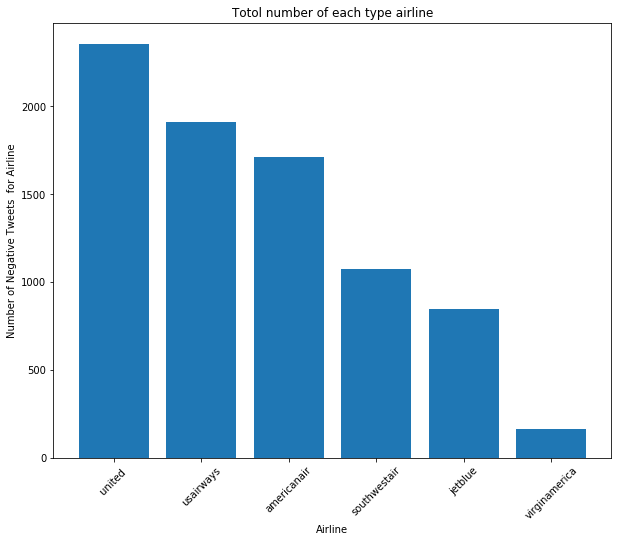

In [23]:

airline = data_negative['mention'].value_counts()
#len(airline)
airline[0:6]
plt.figure(figsize=(10,8))
plt.bar([1,2,3,4,5,6],airline[0:6])
plt.xlabel("Airline")
plt.ylabel("Number of Negative Tweets  for Airline")
plt.title("Totol number of each type airline")
plt.xticks([1,2,3,4,5,6],['united ','usairways','americanair','southwestair','jetblue','virginamerica'],rotation=45)

<Figure size 864x864 with 0 Axes>

(-0.5, 1999.5, 1499.5, -0.5)

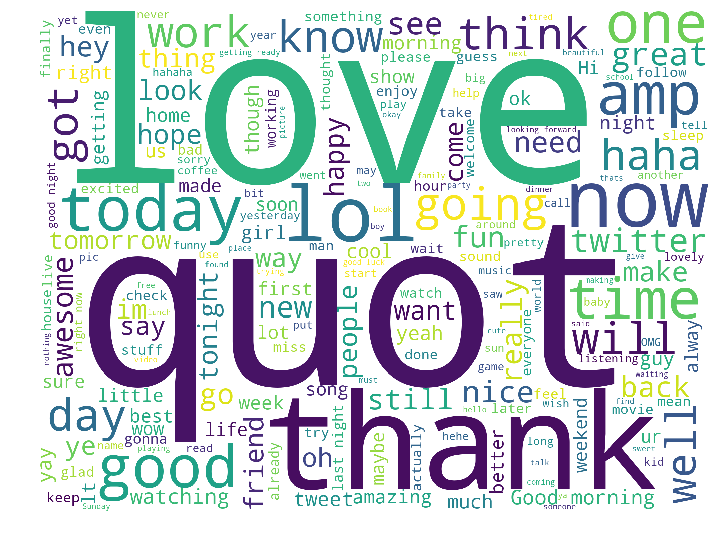

In [24]:
df_generic_wordcloud=data_generic_wordcloud[data_generic_wordcloud['class'] == 4] 
# join tweets to a single string
words = ' '.join(df_generic_wordcloud['text'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Words like "quot", "thank" ,"love", "lol","good"showed frequently in positive tweets. However, "quot" should be taken out after carefully review generic_twitter file.

In [25]:
 ## Use sklearn.feature_selection.chi2 to find the terms that are
# the most correlated with each of the products
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("Most correlated unigrams:\n{}".format('\n'.join(unigrams[-N:])))
    print("Most correlated bigrams:\n {}".format('\n'.join(bigrams[-N:])))
   

# 'Bad Flight':
Most correlated unigrams:
seat
wifi
Most correlated bigrams:
 wifi flight
inflight wifi
# 'Can't Tell':
Most correlated unigrams:
fleets
fleek
Most correlated bigrams:
 worst airline
fleets fleek
# 'Cancelled Flight':
Most correlated unigrams:
flightled
cancelled
Most correlated bigrams:
 flight cancelled
cancelled flightled
# 'Customer Service Issue':
Most correlated unigrams:
service
customer
Most correlated bigrams:
 call back
customer service
# 'Damaged Luggage':
Most correlated unigrams:
wet
damaged
Most correlated bigrams:
 didnt help
baggage handlers
# 'Flight Attendant Complaints':
Most correlated unigrams:
attendant
attendants
Most correlated bigrams:
 flight attendant
flight attendants
# 'Flight Booking Problems':
Most correlated unigrams:
booked
book
Most correlated bigrams:
 trying book
book flight
# 'Late Flight':
Most correlated unigrams:
delay
delayed
Most correlated bigrams:
 late flight
flight delayed
# 'Lost Luggage':
Most correlated unigrams:
luggage


In [26]:
#Train different models from 'test' for negative reasons
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
#Displace the accuracies
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.584552
LogisticRegression        0.596750
MultinomialNB             0.525600
RandomForestClassifier    0.319896
Name: accuracy, dtype: float64

Clearly logistic regression has the best score in all four


References：Susan Li,Multi-Class Text Classification with Scikit-Learn<br>
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f